TODO: 
- ! Think about what plots would suit the current question and hypotheses the best, e.g., histogram?

This notebook contains the preparation of data (0), the modelling of the data (1), and visualisations of the results (2).

#### 0. Prepare the data

##### a) Load the daset containing the speeches

In [1]:
import os
import numpy as np
import pandas as pd

sessions = np.arange(25, 76)
data = []

for session in sessions:
    directory = "data/TXT/Session " + str(session) + " - " + str(1945 + session)
    for filename in os.listdir(directory):
        f = open(os.path.join(directory, filename))
        if filename[0] == ".": #ignore hidden files
            continue
        splt = filename.split("_")
        # Start from 1995
        if session < 50:
            continue
        data.append([session, 1945 + session, splt[0], f.read()])

df_speech = pd.DataFrame(data, columns=['Session','Year','ISO-alpha3 Code','Speech'])
df_speech.head() # Shape: (4913, 4)

,Session,Year,ISO-alpha3 Code,Speech
0,50,1995,BDI,The United Nations is celebrating its fiftieth...
1,50,1995,VNM,"Allow me at the outset, on behalf of the\ndele..."
2,50,1995,PAK,"I extend to you, Sir, my\ndelegation’s felicit..."
3,50,1995,MLI,We\nare meeting on the eve of the fiftieth ann...
4,50,1995,FRA,"Mr. President, I should like to say first how\..."


In [2]:
# Load recent speeches
from pdfminer.high_level import extract_text

folder = f'data/PDF/Session_76 - 2021/'

data = []

for file in os.listdir(folder):
    if file.startswith('.'):
        continue
    f = open(os.path.join(folder, file), "rb")
    splt = file.split("_")
    data.append([76, 2021, splt[0], extract_text(f)])

df_recent = pd.DataFrame(data, columns=['Session','Year','ISO-alpha3 Code','Speech'])

df_speech = pd.concat([df_speech, df_recent]) # Shape: (4923, 4)

df_speech.head()

,Session,Year,ISO-alpha3 Code,Speech
0,50,1995,BDI,The United Nations is celebrating its fiftieth...
1,50,1995,VNM,"Allow me at the outset, on behalf of the\ndele..."
2,50,1995,PAK,"I extend to you, Sir, my\ndelegation’s felicit..."
3,50,1995,MLI,We\nare meeting on the eve of the fiftieth ann...
4,50,1995,FRA,"Mr. President, I should like to say first how\..."


##### b) Load the dataset containing the expenses

Downloaded from https://ec.europa.eu/eurostat/databrowser/view/GOV_10A_EXP__custom_3484912/default/table?lang=en

In [4]:
# Load COFOG
cofog = pd.read_csv("data/gov_10a_exp__custom_3484912_page_tabular.tsv", sep='\t')

cofog.iloc[:,0] = cofog.iloc[:,0].str.split(',').str[-1]
cofog.rename(columns={cofog.columns[0]: "ISO-alpha2 Code"}, inplace=True)

# Perform some preprocessing
cofog = cofog.melt(id_vars=["ISO-alpha2 Code"], var_name="Year", value_name='Expenses')
cofog['Year'] = cofog['Year'].astype(int)
cofog['Expenses'] = cofog['Expenses'].astype(str).str.strip().str.extract(r'(\d+.\d+)').astype('float')

cofog.head()

,ISO-alpha2 Code,Year,Expenses
0,AT,1995,55.8
1,BE,1995,52.6
2,BG,1995,31.7
3,CH,1995,33.3
4,CY,1995,30.9


In [5]:
cofog.loc[:,'ISO-alpha2 Code'] = cofog.loc[:,'ISO-alpha2 Code'].replace('EL', 'GR') # Replace EL with GR to align with ISO

COFOG contains ISO-alpha2 Code while `df_speeches` has ISO-alpha3 codes. We can use the provided UNSD Methodology that contains both.

##### c) Load dataset containing all names of countries and codes

In [6]:
df_codes = pd.read_csv("data/UNSD — Methodology.csv", delimiter=';')

df_un_merged = cofog.merge(df_codes, how='inner') # Df goes from 832 -> 754, but not sure  why!?
df_un_merged = df_un_merged[["ISO-alpha3 Code", "ISO-alpha2 Code", "Expenses", "Country or Area", "Year", "Region Name", "Sub-region Name"]]

df_un_merged.head()

,ISO-alpha3 Code,ISO-alpha2 Code,Expenses,Country or Area,Year,Region Name,Sub-region Name
0,AUT,AT,55.8,Austria,1995,Europe,Western Europe
1,AUT,AT,55.6,Austria,1996,Europe,Western Europe
2,AUT,AT,52.3,Austria,1997,Europe,Western Europe
3,AUT,AT,52.2,Austria,1998,Europe,Western Europe
4,AUT,AT,52.1,Austria,1999,Europe,Western Europe


##### e) Merge datasets
Now we have a COFOG dataframe and a speeches which can be merged with the corresponding `ISO-alpha3` codes and the specific year. We also remove non-European countries.

In [7]:
df_final = df_speech.merge(df_un_merged, how='inner', on=['Year', 'ISO-alpha3 Code'])
df_final.head()

,Session,Year,ISO-alpha3 Code,Speech,ISO-alpha2 Code,Expenses,Country or Area,Region Name,Sub-region Name
0,50,1995,FRA,"Mr. President, I should like to say first how\...",FR,54.8,France,Europe,Western Europe
1,50,1995,IRL,I warmly congratulate the\nPresident on his el...,IE,40.4,Ireland,Europe,Northern Europe
2,50,1995,BEL,“[Today more then ever we should realize that\...,BE,52.6,Belgium,Europe,Western Europe
3,50,1995,ISL,"Mr. President, may I\ncongratulate you on your...",IS,NaN,Iceland,Europe,Northern Europe
4,50,1995,HUN,"May I extend our\ncongratulations to you, Sir,...",HU,55.2,Hungary,Europe,Eastern Europe


##### f) Clean the `Speech` column

In the cleaning, the speeches are tokenized and stopwords and interpunction are removed.

In [8]:
# Copy speech to new column 'Text"
df_final['Text'] = df_final.loc[:,'Speech'].copy()

In [9]:
from nltk import word_tokenize
from nltk.corpus import stopwords

def preprocess(words):
    """
    Returns list with words without stopwords and interpunction
    """
    sw = stopwords.words("english") # Experiment with not removing SW
    clean = []
    for w in words:
        w = str.lower(w)
        if (w.isalpha()) and (w not in sw):
            clean.append(w)

    return clean

# ! Warning, cell takes longer: about 40 seconds
df_final.loc[:,'Text'] = df_final.loc[:,'Text'].apply(word_tokenize)
df_final.loc[:,'Text'] = df_final.loc[:,'Text'].apply(preprocess)

df_final['Text'].values[4][0:10]

['may',
 'extend',
 'congratulations',
 'sir',
 'upon',
 'election',
 'president',
 'general',
 'assembly',
 'historic']

##### g) Quantify the attention for the topic of climate change by  the Member States.

Approach: 
1. We use a labeled dataset which is downloaded from https://www.sustainablefinance.uzh.ch/en/research/climate-fever.html and is based on this paper
https://arxiv.org/abs/2012.00614.
2. We extract the labeled claims and create a list of climate related words.
3. We compare the climate-related words to the words in the speeches and count those.


In [10]:
# Loading the labeled dataset
climate = pd.read_json('data/climate-fever-dataset-r1.jsonl', lines=True)

# Retrieve the values and remove the uncertain ones
climate = climate[(climate.claim_label != 'DISPUTED') & (climate.claim_label != 'NOT_ENOUGH_INFO')]

climate.head()

,claim_id,claim,claim_label,evidences
0,0,Global warming is driving polar bears toward e...,SUPPORTS,[{'evidence_id': 'Extinction risk from global ...
1,5,The sun has gone into ‘lockdown’ which could c...,SUPPORTS,"[{'evidence_id': 'Famine:386', 'evidence_label..."
2,6,The polar bear population has been growing.,REFUTES,"[{'evidence_id': 'Polar bear:1332', 'evidence_..."
3,9,Ironic' study finds more CO2 has slightly cool...,REFUTES,"[{'evidence_id': 'Atmosphere of Mars:131', 'ev..."
4,10,Human additions of CO2 are in the margin of er...,REFUTES,[{'evidence_id': 'Carbon dioxide in Earth's at...


In [11]:
# Extract evidences/evidence instead of claim
# evidences = [i for i in climate.evidences.values]

# res = [] 

# for i in evidences:
#     evi = dict(i[0])
#     for key, value in evi.items():
#         if key == 'evidence_id':
#             res.append(value.split(':')[0])

# res = ' '.join([i for i in set(evidences)])

In [15]:
# Extract claims and clean
claims = ' '.join([i for i in set(climate.claim.values)])
climate_words = word_tokenize(claims)
climate_words = preprocess(climate_words)

print(len(climate_words)) # 10215

10215


Custom list of climate change related words consists out of 757 words.

Count the occurences of climate related words in the speeches 

In [16]:
custom = ['election', 'general', 'united', 'nations', 'france', 'election','european', 'state', 'government', 'agreement', 'great', 'el', 'since']
def count_occurrences(words):
    counts = {}
    count = 0
    for word in climate_words:
        if (word in words) and (word not in custom):
            if word in counts.keys():
                counts[word] += 1
            else:
                counts[word] = 1
    total = sum(counts.values())
    return total

# Warning, cell takes long: over 2m
df_final['Count'] = df_final['Text'].apply(count_occurrences)

In [17]:
df_final['Count'][:10].values

array([2639, 2942, 1937, 2420, 1882, 2651, 2567, 2975, 1907, 2352])

##### h) Handle missing values

In [20]:
df_final.isna().sum()

Session            0
Year               0
ISO-alpha3 Code    0
Speech             0
ISO-alpha2 Code    0
Expenses           3
Country or Area    0
Region Name        0
Sub-region Name    0
Text               0
Count              0
dtype: int64

In [21]:
# df_final["Expenses"].values

Method of mean imputation: fill using country mean

In [22]:
country_grouped = df_final.groupby(['Country or Area'], as_index=False, sort=False)[['Expenses']].mean()
country_grouped["Expenses"] = country_grouped["Expenses"].round(1)
country_grouped.head()

,Country or Area,Expenses
0,France,55.0
1,Ireland,35.6
2,Belgium,52.4
3,Iceland,47.0
4,Hungary,49.3


In [23]:
for i in np.where(df_final['Expenses'].isnull())[0]: 
    print("Missing value for", df_final.iloc[i, 6], "at index", i ,"\n")

Missing value for Iceland at index 3 

Missing value for Iceland at index 33 

Missing value for Iceland at index 72 



In [24]:
df_final = df_final.fillna(country_grouped.loc[df_final['Country or Area'] == "Iceland"][['Expenses']])

In [25]:
df_final

,Session,Year,ISO-alpha3 Code,Speech,ISO-alpha2 Code,Expenses,Country or Area,Region Name,Sub-region Name,Text,Count
0,50,1995,FRA,"Mr. President, I should like to say first how\...",FR,54.8,France,Europe,Western Europe,"[president, like, say, first, pleased, france,...",2639
1,50,1995,IRL,I warmly congratulate the\nPresident on his el...,IE,40.4,Ireland,Europe,Northern Europe,"[warmly, congratulate, president, election, pr...",2942
2,50,1995,BEL,“[Today more then ever we should realize that\...,BE,52.6,Belgium,Europe,Western Europe,"[today, ever, realize, delegations, many, coun...",1937
3,50,1995,ISL,"Mr. President, may I\ncongratulate you on your...",IS,47.0,Iceland,Europe,Northern Europe,"[president, may, congratulate, election, expre...",2420
4,50,1995,HUN,"May I extend our\ncongratulations to you, Sir,...",HU,55.2,Hungary,Europe,Eastern Europe,"[may, extend, congratulations, sir, upon, elec...",1882
...,...,...,...,...,...,...,...,...,...,...,...
767,75,2020,ESP,"Mr. President, Mr. Secretary-General, Ladies a...",ES,52.4,Spain,Europe,Southern Europe,"[president, ladies, gentlemen, heads, state, g...",3121
768,75,2020,CZE,"Mr. President,\nExcellencies,\nLadies and Gent...",CZ,47.2,Czechia,Europe,Eastern Europe,"[president, excellencies, ladies, gentlemen, y...",2243
769,75,2020,MLT,"Secretary General,\nPresident of the General A...",MT,45.9,Malta,Europe,Southern Europe,"[secretary, general, president, general, assem...",2509
770,75,2020,ROU,"Mr. President of the General Assembly,\nMr. Se...",RO,42.0,Romania,Europe,Eastern Europe,"[president, general, assembly, secretary, gene...",2197


##### i) Exploration phase

In [26]:
df_final.columns

Index(['Session', 'Year', 'ISO-alpha3 Code', 'Speech', 'ISO-alpha2 Code',
       'Expenses', 'Country or Area', 'Region Name', 'Sub-region Name', 'Text',
       'Count'],
      dtype='object')

<AxesSubplot: >

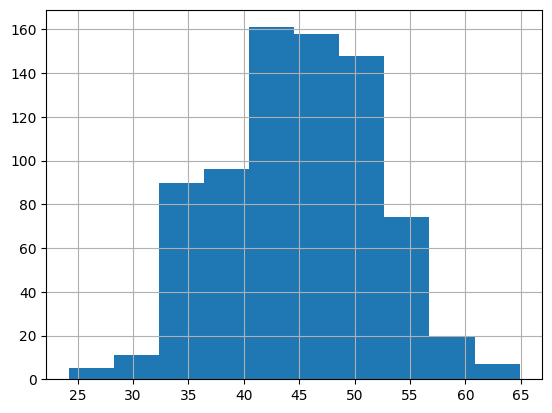

In [27]:
# target value distribution
df_final.Expenses.hist()

In [28]:
# Might come in handy
df_final['Decade'] = df_final['Year'].apply(lambda i: round(i, -1))

- All EU countries expenses and climate change related word count mean, grouped by year

In [29]:
grouped = df_final.groupby(['Year'], as_index=False, sort=False)[['Expenses', 'Count']].sum()
grouped.head()

,Year,Expenses,Count
0,1995,1373.9,60509
1,1996,1297.2,58839
2,1997,1269.9,59116
3,1998,1299.3,59972
4,1999,1309.0,58281


In [30]:
print(grouped[grouped['Count'] == min(grouped['Count'])])
print(grouped[grouped['Count'] == max(grouped['Count'])])

   Year  Expenses  Count
7  2002    1320.0  48228
    Year  Expenses  Count
24  2019    1287.6  71245


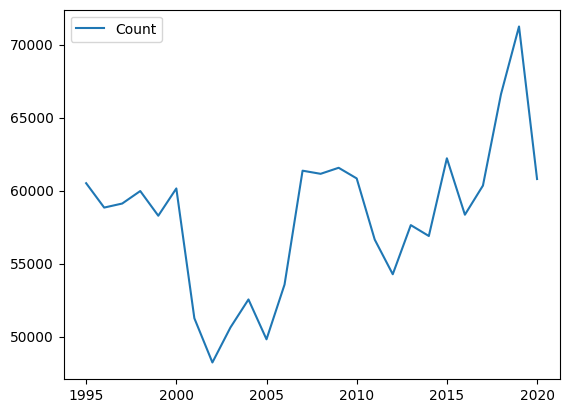

In [31]:
import matplotlib.pyplot as plt

X = grouped['Year'].values
y1 = grouped['Count'].values

plt.plot(X, y1, label="Count")
plt.legend()
plt.show()

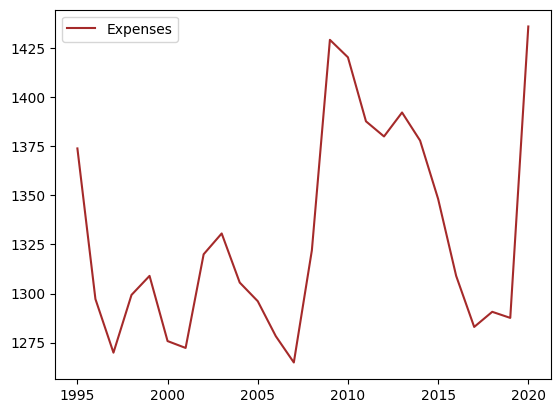

In [32]:
y2 = grouped['Expenses'].values
plt.plot(X, y2, label="Expenses", color='brown')
plt.legend()
plt.show()

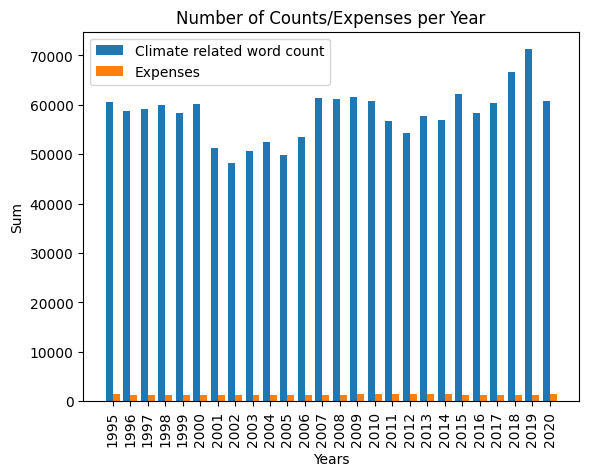

In [33]:
X_axis = np.arange(len(X))
  
plt.bar(X_axis - 0.2, y1, 0.4, label = 'Climate related word count')
plt.bar(X_axis + 0.2, y2, 0.4, label = 'Expenses')
  
plt.xticks(X_axis, X, rotation=90)
plt.xlabel("Years")
plt.ylabel("Sum")
plt.title("Number of Counts/Expenses per Year")

plt.legend()

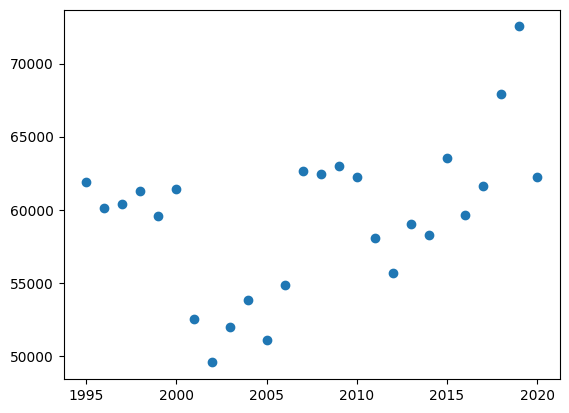

In [34]:
plt.scatter(X,(y1+y2))

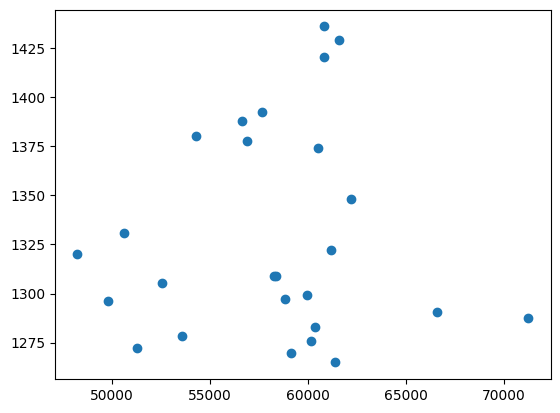

In [35]:
plt.scatter(y1, y2)

Scatter plot suggests a linear relation between counts and expenses

From here some extra exploration

- EU countries grouped by region and interested in expenses and climate change related word count mean

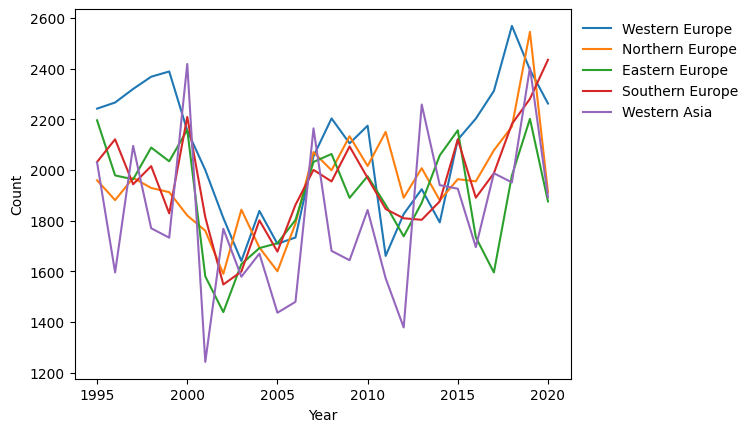

In [36]:
import seaborn as sns

# Climate related word count for regions (in EU)
df = df_final.groupby(['Year', 'Sub-region Name'], as_index=False, sort=False)[['Expenses','Count']].mean()

ax = sns.lineplot(x="Year", y="Count", hue='Sub-region Name', data=df, palette='tab10')
ax.legend(ncol=1, bbox_to_anchor=(1, 1), frameon=False)

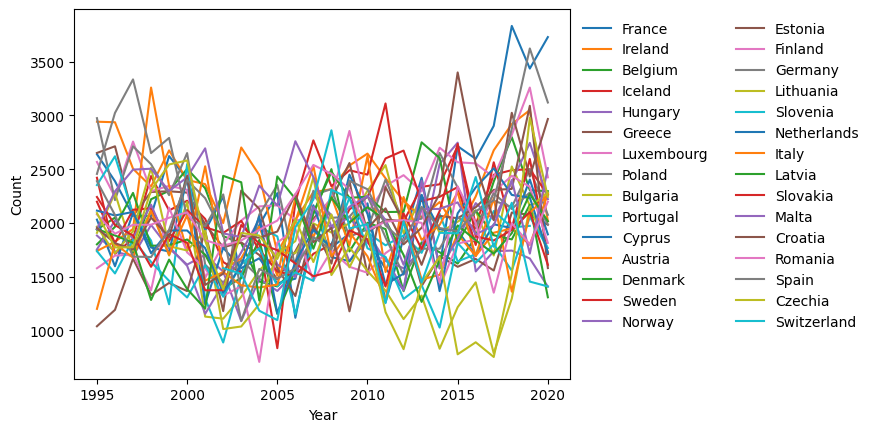

In [37]:
# Climate related word count for countries (in EU)
ax = sns.lineplot(x="Year", y="Count", hue='Country or Area', data=df_final, palette='tab10')
ax.legend(ncol=2, bbox_to_anchor=(1, 1), frameon=False)

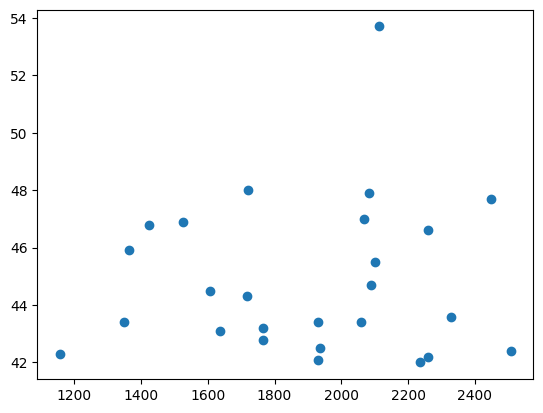

In [38]:
df_west = df_final[df_final['Country or Area'] == 'Netherlands']

X = df_west['Count']
y = df_west['Expenses']

plt.scatter(X, y)

##### j) Exploration phase: Top word frequencies 


In [39]:
df_final["Speech"]

0      Mr. President, I should like to say first how\...
1      I warmly congratulate the\nPresident on his el...
2      “[Today more then ever we should realize that\...
3      Mr. President, may I\ncongratulate you on your...
4      May I extend our\ncongratulations to you, Sir,...
                             ...                        
767    Mr. President, Mr. Secretary-General, Ladies a...
768    Mr. President,\nExcellencies,\nLadies and Gent...
769    Secretary General,\nPresident of the General A...
770    Mr. President of the General Assembly,\nMr. Se...
771    Mr President, Excellencies\nAll protocol obser...
Name: Speech, Length: 772, dtype: object

In [40]:
# create topic modeling data

TM_data = df_final["Speech"].tolist()

TM_data = [x.replace("\n", " ") for x in TM_data] # remove the \n 

print(f'Number of documents: {len(TM_data)}')

Number of documents: 772


In [41]:
import numpy as np
import math

def show_vocabulary(vectorizer, word_size=15, words_per_line=10):
    words = vectorizer.get_feature_names()

    word_format = f'<{word_size}'
    for l in np.array_split(words, math.ceil(len(words) / words_per_line)):
        print(''.join([f'{x:{word_format}}' for x in l]))

In [42]:
from sklearn.feature_extraction.text import CountVectorizer

count = CountVectorizer()
count.fit(TM_data)
print(f'Size of corpus vocabulary: {len(count.get_feature_names())}')

Size of corpus vocabulary: 18727


/usr/local/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Show most frequent words per Subregion

In [43]:
df_final["Sub-region Name"].unique()

array(['Western Europe', 'Northern Europe', 'Eastern Europe',
       'Southern Europe', 'Western Asia'], dtype=object)

In [44]:
#create the subregion data

def data_Sub(df_subregion):
    df_subregion = df_final[df_final["Sub-region Name"] == df_subregion]
    return df_subregion['Speech'].tolist()

data_WE = data_Sub('Western Europe')
data_NE = data_Sub('Northern Europe')
data_EE = data_Sub('Eastern Europe')
data_SE = data_Sub('Southern Europe')
data_WA = data_Sub('Western Asia')

In [45]:
def nremover(data):
    new_data = []
    for x in data:
        new_data.append(x.replace("\n", " "))
        return new_data

data_WE = nremover(data_WE)
data_NE = nremover(data_NE)
data_EE = nremover(data_EE)
data_SE = nremover(data_SE)
data_WA = nremover(data_WA)

In [46]:
#new custom stop words to add
import nltk

new_stopwords = ["united nations", "nations", "united", "organization", "also", "assembly", "general", "must", "community", "council", "conference", "charter", "France"]
stpwrd = nltk.corpus.stopwords.words('english')
stpwrd.extend(new_stopwords)

In [47]:
nltk.download('stopwords')
nltk.download('wordnet')
sw = stopwords.words('english')

count = CountVectorizer(
    stop_words=stpwrd,         #with stopwords excluded
    token_pattern=r'[a-z]+',   #fliter token pattern to only alphabetical
    ngram_range=(1, 2),        #include singular words and bigrams
    max_features=50            #retain only top 50 tokens based on the nr of times they appear in complete corpus   
)

def top_voc(data_subregion, subregion):
    """
    Returns the 50 most frequent words per subregion with the above parameters set ^
    """
    count.fit(data_subregion)
    vocab_top = count.get_feature_names()
    print("50 most frequent words of",subregion + ":\n")
    show_vocabulary(count) 
    print("\n")

top_voc(data_WE, 'Western Europe')
top_voc(data_NE, 'Northern Europe')
top_voc(data_EE, 'Eastern Europe')
top_voc(data_SE, 'Southern Europe')
top_voc(data_WA, 'Western Asia')

50 most frequent words of Western Europe:

agreement      countries      development    disarmament    europe         european       european union first          force          france         
held           however        important      international  keeping        last           like           major          make           may            
member         member states  new            nuclear        operations     peace          peace keeping  president      principles     progress       
region         respect        security       set            since          states         struggle       treaty         two            union          
upon           us             values         weapons        within         work           world          would          year           years          


50 most frequent words of Northern Europe:

anniversary    commitment     communities    conflict       continue       cooperation    countries      development    governments    great          
human

[nltk_data] Downloading package stopwords to /Users/mayla/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/mayla/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
/usr/local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:404: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['france'] not in stop_words.
  warnings.warn(


Testing claim that lemmatizer may improve the detection of similar texts

In [48]:
from sklearn.metrics.pairwise import cosine_similarity
from nltk.stem.wordnet import WordNetLemmatizer

count_vanilla = CountVectorizer()
count_vanilla.fit(TM_data)

tokenizer = CountVectorizer().build_tokenizer()

wn = WordNetLemmatizer()
def lemmatizer(text):
    tokens = tokenizer(text)
    return map(wn.lemmatize, tokens)

count_lemma = CountVectorizer(
    tokenizer=lemmatizer, 
)
count_lemma.fit(TM_data)

text_01 = 'It is hard to make a tree grow strong'
text_02 = 'I like growing trees and making them strong'

for name, vectorizer in zip(['No Lemma', 'Lemma'], [count_vanilla, count_lemma]):
    bows = vectorizer.transform([text_01, text_02])
    similarity = cosine_similarity(bows)
    print(f'{name:<8}: Cosine Similarity = {similarity[0, 1]:0.2f} with {bows.shape[1]:>4d} dimensions')

/usr/local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:524: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


No Lemma: Cosine Similarity = 0.13 with 18727 dimensions
Lemma   : Cosine Similarity = 0.27 with 16613 dimensions


By including a lemmatizer, the cosine similarity between the texts becomes bigger, ie. a lemmatizer is better at detecting when two texts are similar to eachother

##### k) Exploration phase: Topic modeling

In [49]:
count = CountVectorizer()
count.fit(TM_data)

vocab_df = count.get_feature_names()
print(f'Size of vocabulary: {len(vocab_df)}')

Size of vocabulary: 18727


In [50]:
# improving the quality of the vocabulary

count = CountVectorizer(
    stop_words=stpwrd,
    token_pattern=r'[a-z]+',
    ngram_range=(1, 2), 
    tokenizer=lemmatizer,      #including the lemmatizer to reduce words to their stem
    min_df=5,                  #word should be in min 5 speeches
    max_df=0.8                #word should be in max 80% of speeches
)
count.fit(TM_data)

vocab_df = count.get_feature_names()
print(f'Size of vocabulary: {len(vocab_df)}')

/usr/local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:404: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['doe', 'france', 'ha', 'nation', 'wa'] not in stop_words.
  warnings.warn(


Size of vocabulary: 28005


In [51]:
import spacy

nlp = spacy.load('en_core_web_sm')

add_stops = stpwrd

stopped_tokenized = list(map(
    lambda tokens: [t.text for t in tokens if len(t.text) > 1 and not t.is_stop and t.text not in add_stops],
    nlp.tokenizer.pipe(TM_data)
))

In [52]:
from gensim.corpora.dictionary import Dictionary
from gensim.models.phrases import Phrases

dictionary = Dictionary(stopped_tokenized)
dictionary.filter_extremes(no_below=5, no_above=0.8)
dictionary.compactify()

corpus = [dictionary.doc2bow(txt) for txt in stopped_tokenized]

In [53]:
# perform LDA on corpus

from gensim.models.ldamodel import LdaModel

lda = LdaModel(
    corpus=corpus, 
    id2word=dictionary,
    num_topics=10,          #tries to find these number of topics
    alpha='auto',
    eta='auto',
    iterations=100,
    passes=20,
    eval_every=None,
    random_state=42,
    per_word_topics=True
)

In [54]:
lda.print_topics()

[(0,
  '0.015*"Cyprus" + 0.009*"Greece" + 0.008*"European" + 0.007*"Turkish" + 0.007*"Turkey" + 0.007*"solution" + 0.006*"  " + 0.006*"region" + 0.005*"Union" + 0.005*"State"'),
 (1,
  '0.010*"  " + 0.006*"climate" + 0.006*"change" + 0.004*"sustainable" + 0.004*"women" + 0.004*"responsibility" + 0.003*"today" + 0.003*"action" + 0.003*"Development" + 0.003*"   "'),
 (2,
  '0.021*"pandemic" + 0.020*"UN" + 0.012*"COVID-19" + 0.007*"crisis" + 0.007*"President" + 0.006*"Ladies" + 0.005*"law" + 0.005*"Finland" + 0.005*"nuclear" + 0.004*"Gentlemen"'),
 (3,
  '0.011*"Malta" + 0.009*"  " + 0.009*"Ireland" + 0.007*"Union" + 0.006*"European" + 0.006*"Mediterranean" + 0.005*"process" + 0.004*"Organization" + 0.004*"conflict" + 0.004*"commitment"'),
 (4,
  '0.007*"  " + 0.004*"conflict" + 0.004*"law" + 0.003*"Europe" + 0.003*"change" + 0.003*"responsibility" + 0.003*"freedom" + 0.003*"today" + 0.003*"crisis" + 0.003*"order"'),
 (5,
  '0.019*"Portugal" + 0.010*"Sweden" + 0.007*"Portuguese" + 0.005*"

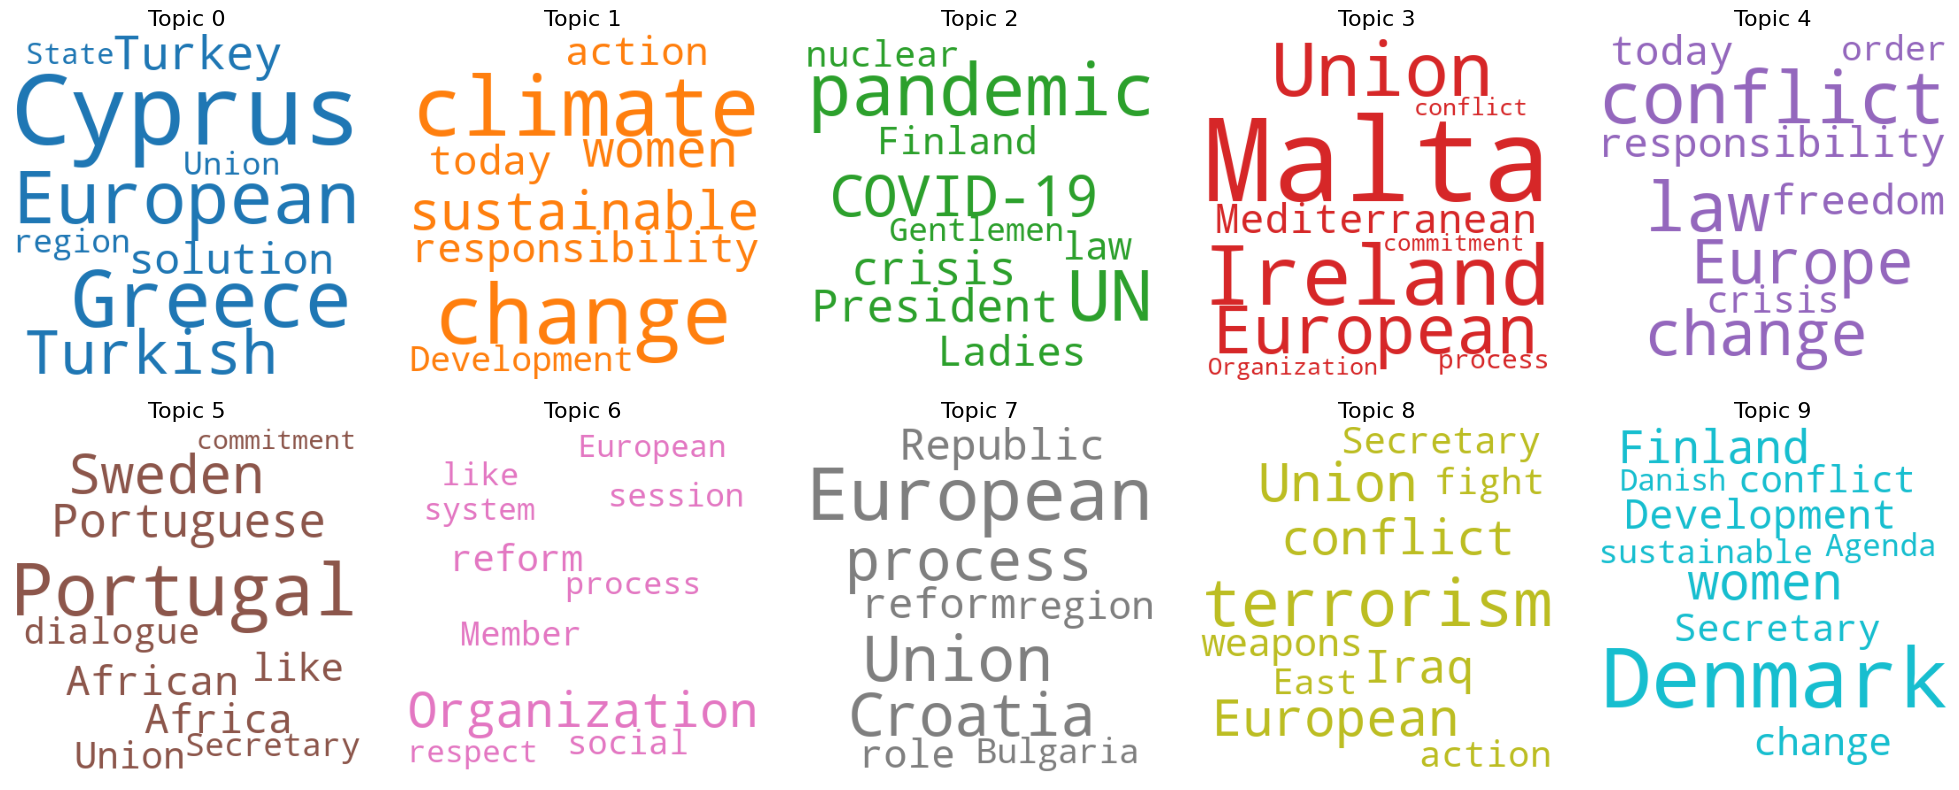

In [55]:
import math
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import wordcloud
from wordcloud import WordCloud, STOPWORDS

nb_columns = 5
K = 10
nb_rows = math.ceil(K / nb_columns)

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
cols = cols * math.ceil(K / len(cols))

cloud = WordCloud(background_color='white',
                  width=400,
                  height=400,
                  max_words=10,
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda.show_topics(num_topics=K, num_words=10, formatted=False)

fig, axes = plt.subplots(ncols=nb_columns, nrows=nb_rows, 
                         figsize=(4*nb_columns, 4*nb_rows), 
                         sharex=True, sharey=True)

for i, (topic, ax) in enumerate(zip(topics, axes.flatten())):
    topic_words = dict(topic[1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    ax.imshow(cloud)
    ax.set_title('Topic ' + str(i), fontdict=dict(size=16))
    ax.axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

In [56]:
# give all the topic names and select the topic most close to environment
names = [
    'Cyprus', 
    'Organizations role',
    'Nuclear',
    'Bulgaria',
    'East region',
    'Climate change',
    'Crisis',
    'Europes responsibility',
    'Terrorism',
    'Development'
]

topic_names = {i: v for i, v in enumerate(names)}
display(topic_names)

select_topic = 5

{0: 'Cyprus',
 1: 'Organizations role',
 2: 'Nuclear',
 3: 'Bulgaria',
 4: 'East region',
 5: 'Climate change',
 6: 'Crisis',
 7: 'Europes responsibility',
 8: 'Terrorism',
 9: 'Development'}

In [57]:
by_get_document_topics = list(map(lda.get_document_topics, corpus))

In [59]:
for topic_id, value in by_get_document_topics[0]:
    print(f'Topic #{topic_id:2d} ({topic_names[topic_id]:<20}): {value:>4.3f}')
print('-' * 40)
print(f'Sum {sum(x[1] for x in by_get_document_topics[0]):>35.3f}')

Topic # 3 (Bulgaria            ): 0.089
Topic # 6 (Crisis              ): 0.906
----------------------------------------
Sum                               0.994


Great majority of the speeches could be classified as belonging to the "Organizations role" topic

#### 1. Modelling

In [60]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

X = preprocessing.scale(grouped['Count'].values) # Standardizing X
y = preprocessing.scale(grouped['Expenses'].values) # and Y

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [61]:
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline

lm_model = make_pipeline (
    LinearRegression(fit_intercept=True)
)

lm_model.fit(X_train[:, np.newaxis], y_train)

xfit = np.linspace(min(X), max(X), 9)
pred_y = lm_model.predict(xfit[:, np.newaxis])

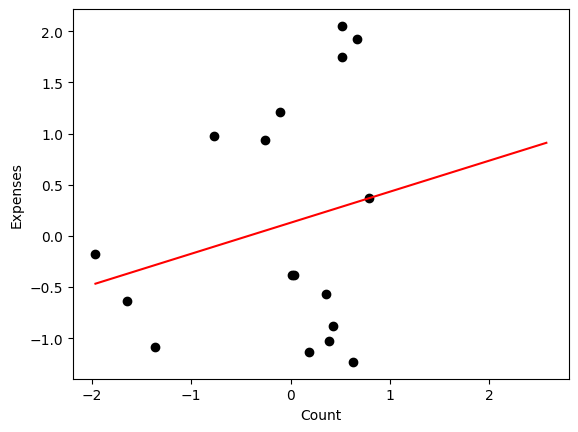

In [62]:
fig, ax = plt.subplots(1)

ax.scatter(X_train, y_train, c='black')
ax.set_xlabel("Count")
ax.set_ylabel("Expenses")

ax.plot(xfit, pred_y, c='red');
plt.show()


In [63]:
from sklearn.metrics import mean_squared_error, r2_score

# Evaluate the model
# The mean squared error
print("Mean squared error - Test: %.2f" % mean_squared_error(y_test, pred_y))
# Explained variance score: 1 is perfect prediction
print('Variance score - Test: %.2f' % r2_score(y_test, pred_y))

Mean squared error - Test: 1.23
Variance score - Test: -1.52


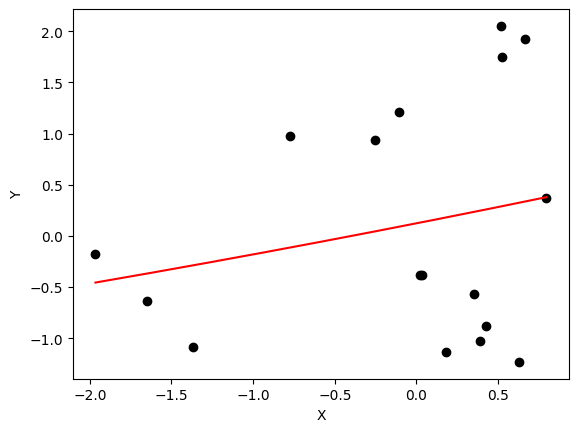

In [64]:
from sklearn.preprocessing import PolynomialFeatures

X_train, X_test, y_train, y_test = train_test_split(X, y, \
    test_size=0.33, random_state=42)

polymodel = make_pipeline(PolynomialFeatures(2), LinearRegression(fit_intercept=True))

polymodel.fit(X_train[:, np.newaxis], y_train)

xfit = np.linspace(min(X_train), max(X_train), 9)

y_pred = polymodel.predict(xfit[:, np.newaxis])

fig, ax = plt.subplots()
ax.scatter(X_train, y_train, c='black')

ax.set_xlabel("X")
ax.set_ylabel("Y")

ax.plot(xfit, y_pred, c='red');
plt.show()

In [65]:
# The mean squared error
print("Mean squared error - Test: %.2f" % mean_squared_error(y_test, y_pred))
# Explained variance score: 1 is perfect prediction
print('Variance score - Test: %.2f' % r2_score(y_test, y_pred))


Mean squared error - Test: 0.81
Variance score - Test: -0.65


#### 2. Visualisation

Remember the principles of data visualisation: 
1. Know the audience: Curse of expertise, informative labels.
2. One plot, one message.
3. Adapt figure to medium: Thicker lines, less information for smaller mediums.
4. Caption! 
5. Do not trust the defaults (especially in Matplotlib)
6. Use color effectively. Color maps: sequential vs diverging vs qualitative.

    *Diverging* = if there’s a meaningful middle point
    
    *Sequential* = for a more intuitive reading
7. Avoid chartjunk = unnecessary visual elements
8. Do not mislead audience
9. Chose message over beauty
10. Know and use the right tool: matplotlib, seaborn, geopandas, networkX.


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set styling parameters for sns
sns.set_theme(); sns.set_context('notebook'); sns.set_style('ticks')

Linegraph

In [ ]:
#TODO Plot lingraph: X = Year, Y = Expenses, Lines = Different countries?
# ax = sns.lineplot(x="Year", y="Count", hue='Sub-region Name', data=grouped, palette='tab10')
# ax.legend(ncol=2, bbox_to_anchor=(1, 1), frameon=False)

Scatterplot

In [ ]:
# Scatterplot: X = Year, Y = Expenses, Dot = Country
# df_west = df_speech[df_speech['Sub-region Name'] == 'Western Europe']
# ax = sns.scatterplot(x="Count", y="Expenses", hue='Country or Area', data=df_west)
# ax.legend(ncol=2, frameon=False)

Histogram

In [ ]:
#TODO Plot histogram: group data by ISO....

Geopandas

In [ ]:
# import geopandas

# world = geopandas.read_file(geopandas.datasets.get_path("naturalearth_lowres"))
# europe = world.merge(df_speech, how='inner', left_on='name', right_on='Country or Area')

In [ ]:
# ax = world.plot(, color='white', edgecolor='black')
# fig, ax = plt.subplots(1)
# europe.plot(column='Count', ax=ax, legend=True)